# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [39]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from worclipo.load_data import load_data

### functions

In [40]:
# function to split the dataset into train and test
def split_set(X,y,test_size):

    if os.path.exists('./TEST_set.csv'):
        split_action = print('TEST_set.csv already exists')
    else:
        split_action = print('TEST_set.csv does not exist, generating new test and training sets')
        X_train_csv, X_test_csv, y_train_csv, y_test_csv = train_test_split(X, y, test_size=test_size, random_state=10)

        TESTSET = X_test_csv.merge(y_test_csv, left_index=True, right_index=True)
        TESTSET.to_csv('TEST_set.csv')

        TRAINSET = X_train_csv.merge(y_train_csv, left_index=True, right_index=True)
        TRAINSET.to_csv('TRAIN_set.csv')
        return split_action
    

# setting up the data to be processed

In [41]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(type(data))

# change lipoma = 1 and liposarcoma = 0 and encode labels
group_names = list(set(data.label))
data.loc[data['label'] == 'lipoma', 'label'] = 1
data.loc[data['label'] == 'liposarcoma', 'label'] = 0
data['label'] = pd.cut(data['label'], bins = 2, labels=group_names)
print(data['label'].unique())
label_diag = LabelEncoder()
data['label'] = label_diag.fit_transform(data['label'])

# assign X to measurements and y to outcome (lipoma/sarcoma)
X = data.drop('label', axis=1)
y = data['label']
test_size = 0.3

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
['lipoma', 'liposarcoma']
Categories (2, object): ['lipoma' < 'liposarcoma']


In [42]:
# code that splits the data into test and validation sets if this is not done already
split_set(X,y,test_size)

TEST_set.csv already exists


## import the training set

In [43]:
TRAIN = pd.read_csv('TRAIN_set.csv', index_col=0)
X_train = TRAIN.drop('label', axis=1)
y_train = TRAIN['label']

TRAIN['label'] = pd.cut(TRAIN['label'], bins = 2, labels=group_names)
print(TRAIN['label'].unique())
label_diag = LabelEncoder()
TRAIN['label'] = label_diag.fit_transform(TRAIN['label'])

# split into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=10)

# scale the training set
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

# preprocess the data 
if not str in data.values:
    print(f'All values are numerical.')
if np.isnan(X_train).any():
    imp = SimpleImputer(missing_value=np.nan, strategy='mean')
    X_train.iloc[:,:] = imp.fit_transform(X_train)
    X_valid.iloc[:,:] = imp.fit(X_valid)
    print(f'All NaN values replaced by mean value of the column.')

# remove features with zero variance
print(f'Size before removal zero variances: ', X_train.shape)
vt = VarianceThreshold(threshold=0)
X_train = vt.fit_transform(X_train)
X_valid = vt.transform(X_valid)
print(f'Size after removal zero variance: ', X_train.shape)

['lipoma', 'liposarcoma']
Categories (2, object): ['lipoma' < 'liposarcoma']
All values are numerical.
Size before removal zero variances:  (56, 493)
Size after removal zero variance:  (56, 474)


# Classify

In [44]:

# try a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_valid)

print('rfc', classification_report(y_valid, pred_rfc))
print(confusion_matrix(y_valid, pred_rfc))

rfc               precision    recall  f1-score   support

           0       0.53      0.91      0.67        11
           1       0.80      0.31      0.44        13

    accuracy                           0.58        24
   macro avg       0.66      0.61      0.56        24
weighted avg       0.67      0.58      0.55        24

[[10  1]
 [ 9  4]]


Feature ranking:
1. feature 20 (0.018971)
2. feature 306 (0.013717)
3. feature 202 (0.013541)
4. feature 203 (0.010368)
5. feature 307 (0.009913)
6. feature 70 (0.009700)
7. feature 311 (0.009090)
8. feature 197 (0.008917)
9. feature 199 (0.008916)
10. feature 198 (0.008539)
11. feature 310 (0.008201)
12. feature 323 (0.008130)
13. feature 366 (0.007823)
14. feature 201 (0.007707)
15. feature 6 (0.007338)
16. feature 424 (0.007154)
17. feature 340 (0.007147)
18. feature 275 (0.007104)
19. feature 254 (0.006707)
20. feature 67 (0.006560)
21. feature 58 (0.006337)
22. feature 429 (0.006220)
23. feature 19 (0.006023)
24. feature 11 (0.005921)
25. feature 358 (0.005889)
26. feature 272 (0.005617)
27. feature 255 (0.005612)
28. feature 413 (0.005519)
29. feature 443 (0.005390)
30. feature 327 (0.005222)
31. feature 434 (0.005014)
32. feature 17 (0.005004)
33. feature 66 (0.004980)
34. feature 301 (0.004969)
35. feature 230 (0.004794)
36. feature 362 (0.004687)
37. feature 253 (0.004676)
38.

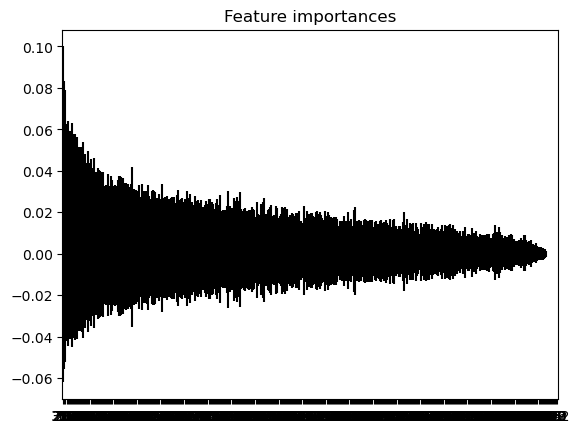

In [55]:

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_valid.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_valid.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_valid.shape[1]), indices)
plt.xlim([-1, X_valid.shape[1]])
plt.show()